# Vision to Text Translations using a Global Workspace
Benjamin Devillers

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ruflab/shimmer-tutorials/blob/main/simple-shapes-dataset-inference.ipynb)


In this notebook, we will see how to use `shimmer` and our pretrained models. We will use our pretrained model to translate visual images of shapes from the [simple-shapes-datset](https://github.com/ruflab/simple-shapes-dataset) to their text descriptions.

For this tutorial, we will need to install the [shimmer-ssd](https://github.com/ruflab/shimmer-ssd) package.

In [ ]:
!pip install "git+https://github.com/ruflab/shimmer-ssd.git"

This package depends on [simple-shapes-dataset](https://github.com/ruflab/simple-shapes-dataset) and provides all of its commands. You can then use all of its commands.

For instance, we can download the dataset directly with:

In [ ]:
!shapesd download

Note that `shapesd download` automatically migrates the dataset so that it is correctly formatted. If you downloaded the dataset manually, use `shapesd migrate -p PATH_TO_DATASET` to migrate manually.

Our evaluation will also require the simple-shapes dataset tokenizer data, so let's download this from the `shimmer-ssd` repository:

In [ ]:
!ssd download tokenizer

Let's now import what we will need in this notebook.

In [1]:
from collections.abc import Mapping
from pathlib import Path
from typing import cast

import matplotlib
import matplotlib.pyplot as plt
import torch
from lightning.pytorch import seed_everything
from shimmer.modules.global_workspace import GlobalWorkspaceFusion
from shimmer.modules.selection import SelectionBase
from shimmer_ssd import DEBUG_MODE, PROJECT_DIR
from shimmer_ssd.config import DomainModuleVariant, LoadedDomainConfig, load_config
from shimmer_ssd.dataset.pre_process import TokenizeCaptions
from shimmer_ssd.logging import batch_to_device
from shimmer_ssd.modules.domains import load_pretrained_domains
from shimmer_ssd.modules.domains.visual import VisualLatentDomainModule
from tokenizers.implementations.byte_level_bpe import ByteLevelBPETokenizer
from torchvision.utils import make_grid

from simple_shapes_dataset import SimpleShapesDataModule, get_default_domains

%matplotlib inline

## Config

Let's first generate the config folder for the rest of the scripts.
This will create a `config` folder with different yaml files used by the different scripts and in the notebook.

In [2]:
!ssd config create

Config folder already exists. Skipping.


This will create a `config` folder. This contains many file, but in this tutorial, only `main.yaml` will interest us.

You can start by taking a look at the default values which should be mostly set correctly for this tutorial. But you can try and make some changes to see the outcome.

<div class="alert alert-info">
Anytime you make a change to the config, don't forget to reload it with the following cell!
</div>

In [3]:
# We don't use cli in the notebook, but consider using it in normal scripts.
config = load_config("./config", use_cli=False)

## Make the dataloader

Thanks to `shapesd download`, we should now have our dataset in the folder "simple_shapes_dataset". This should be the path set in `main.yaml`:
```yaml
dataset:
    path: "./simple_shapes_dataset"
```


We now need to define which modality we will load, and in what proportion. Open `config/main.yaml` and update `domain_proportions` with selected values:

```yaml
domain_proportions: 
    -   domains: ["v"]  # unimodal visual passes use 100% of the available data 
        proportion: 1.0
    -   domains: ["t"]  # unimodal text passes use 100% of the available data
        proportion: 1.0
    -   domains: ["v", "t"]  # paired passes uses 100% of the available data
        proportion: 1.0
```


To use this proportion, we need to create a split in the dataset. A dataset split depends on a seed and the proportion of each group of domain.
We only need to generate this split once.

This can be done with the `shapesd alignment add` command. It needs the following arguments:
- `--dataset_path "DATASET_PATH"`: the location where the dataset is stored
- `--seed SEED` the split seed
- `--domain_alignment DOMAIN_1,DOMAIN_2,...DOMAIN_N PROP` the proportion for each domain group. This corresponds to what has been defined in `domain_proportion`

When running this command, it will create a file containing the indices of the items available in the train set (update so that it matches what we set in the config file).


In [4]:
!shapesd alignment add --dataset_path "simple_shapes_dataset" --seed 0 --domain_alignment t 1.0 --domain_alignment v 1.0 --domain_alignment t,v 1.0

We also need to get the class used to load the different domains. For that, we can use `get_default_domains` and give as a parameter the list of domain loaders that we need. 

Here are the main available loaders, listed in the `DomainType` enum:
- `DomainType.v`: visual model using a pretrained VAE.
- `DomainType.v_latents`: same as `v`, but starting from the VAE latent representation. This is used for faster inference by short-circuiting the VAE.
- `DomainType.attr`: attribute (proto-language) module using a VAE.
- `DomainType.attr_legacy`: legacy version (from Devillers et al., 2024) of the attibute module using the attribute as the latent representation directly (no VAE).
- `DomainType.t`: natural language module.

Here, we will focus on vision to text, and we will select `v_latents` and `t`.

In [5]:
# Then we get the data domain that will load the data for our two different domain
# formats:
# - `t` will load the text (with bert representations of the sentences
# - `v_latents` will load pre-saved latent representations of the visual VAE.
domain_classes = get_default_domains(["v_latents", "t"])
print(domain_classes)

{DomainDesc(base='v', kind='v_latents'): <class 'simple_shapes_dataset.domain.SimpleShapesPretrainedVisual'>, DomainDesc(base='t', kind='t'): <class 'simple_shapes_dataset.domain.SimpleShapesText'>}


`v_latents` will allow us to use the pretrained model provided in the [`shimmer-ssd`](https://github.com/ruflab/shimmer-ssd) repo.
However, it requires pre-saved latent representations of the visual VAE.

We can first download the checkpoinst, then extract the visual latents with:

In [6]:
!ssd download checkpoints
!mv checkpoints/checkpoints/* checkpoints/
!rm -rf checkpoints/checkpoints

  0%|                                                | 0.00/288M [00:00<?, ?B/s]
  0%|                                        | 246k/288M [00:00<02:20, 2.05MB/s]
  2%|▌                                      | 4.42M/288M [00:00<00:11, 23.6MB/s]
  5%|██                                     | 15.2M/288M [00:00<00:04, 60.5MB/s]
  8%|███                                    | 22.5M/288M [00:00<00:04, 65.2MB/s]
2745it [00:00, 7773.54it/s]
 14%|█████▎                                 | 39.4M/288M [00:00<00:03, 74.0MB/s]
4813it [00:00, 9075.22it/s]
 19%|███████▌                               | 56.0M/288M [00:00<00:03, 76.6MB/s]
 23%|█████████▏                             | 67.5M/288M [00:00<00:02, 87.8MB/s]
 27%|██████████▌                            | 78.3M/288M [00:01<00:02, 93.9MB/s]
 31%|████████████                           | 89.4M/288M [00:01<00:02, 99.0MB/s]
 35%|██████████████▎                          | 101M/288M [00:01<00:01, 103MB/s]
 39%|███████████████▊                         | 111M/

In [7]:
!ssd extract v "checkpoints/domain_v.ckpt" -p "simple_shapes_dataset"

Saving train.
100%|█████████████████████████████████████████| 244/244 [00:27<00:00,  8.91it/s]
Saving in simple_shapes_dataset/saved_latents/train/domain_v.npy.
Saving val.
100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  9.37it/s]
Saving in simple_shapes_dataset/saved_latents/val/domain_v.npy.
Saving test.
100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  8.99it/s]
Saving in simple_shapes_dataset/saved_latents/test/domain_v.npy.


We now need to set the location of the presaved latent vectors in the config file. You can see that `domain_data_args` is defined as follows:

```yaml
domain_data_args:
    v_latents:
        presaved_path: domain_v.npy  # same name as `domain_v.ckpt`
```

And now let's define text transforms to change the text input as a token sequence.

You can already change the path to the tokenizer vocab and merges file in:
```yaml
domain_modules:
    text:
        vocab_path: ./tokenizer/vocab.json
        merges_path: ./tokenizer/merges.txt
```


In [8]:
seq_length = 64  # we will use a sequence length of 64

# And define a transform for the text domain to tokenize the text string
additional_transforms = {
    "t": [TokenizeCaptions(config.domain_modules.text.vocab_path, config.domain_modules.text.merges_path, seq_length)]
}
tokenizer = ByteLevelBPETokenizer(config.domain_modules.text.vocab_path, config.domain_modules.text.merges_path)

Finally, let's define some arguments:

In [9]:
seed_everything(config.seed, workers=True)

# initilize the lightning data module
data_module = SimpleShapesDataModule(
    config.dataset.path,
    domain_classes,
    config.domain_proportions,
    config.training.batch_size,
    seed=config.seed,
    domain_args=config.domain_data_args,
    additional_transforms=additional_transforms,
)

Seed set to 0


## Load pretrained Model

The checkpoints are stored in "./checkpoints" after `ssd download checkpoints`.

Let's now define which pretrained domain module we will use for the model. You can update the `domains` section of the config:
```yaml
domains:
    - checkpoint_path: "#{default_root_dir}/domain_v.ckpt"
      domain_type: v_latents
    - checkpoint_path: "#{default_root_dir}/domain_t.ckpt"
      domain_type: t
```

Note here that we define the path relative to `#{default_root_dir}` which is replaced by the value set in `default_root_dir` ("./checkpoints").

We also need to update the dimensions of the encoders and decoders that will translate the unimodal latent representations through the global workspace.

```yaml
global_workspace:
    latent_dim: 16  # This changed compared to the default config!

    encoders:
        hidden_dim: 32
        n_layers: 32

    decoders:
        hidden_dim: 32
        n_layers: 3
```

In [10]:
# After some config changes, don't forget to reload the changes!
config = load_config("./config", use_cli=False)

To make sure this tutorial runs without manually changing the config, the following line will force the correct value to be set.
You don't need to run it if you made the correct change in the config.

In [11]:
config.global_workspace.latent_dim = 16  # latent dim of the pretrained gw

In [12]:
# we load the pretrained domain modules and define the associated GW encoders and
# decoders
domain_modules, gw_encoders, gw_decoders = load_pretrained_domains(
    config.domains,
    config.global_workspace.latent_dim,
    config.global_workspace.encoders.hidden_dim,
    config.global_workspace.encoders.n_layers,
    config.global_workspace.decoders.hidden_dim,
    config.global_workspace.decoders.n_layers,
)

Let's now load a pre-trained global workspace trained to align vision and texts.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# And now we load the GW checkpoint
checkpoint_path = Path("./checkpoints")
checkpoint = checkpoint_path / "gw-t-v_e6sm51xy.ckpt"

global_workspace = GlobalWorkspaceFusion.load_from_checkpoint(
    checkpoint,
    domain_mods=domain_modules,
    gw_encoders=gw_encoders,
    gw_decoders=gw_decoders,
)
global_workspace.to(device)

GlobalWorkspaceFusion(
  (gw_mod): GWModule(
    (domain_mods): ModuleDict(
      (v_latents): VisualLatentDomainModule(
        (visual_module): VisualDomainModule(
          (vae): VAE(
            (encoder): RAEEncoder(
              (layers): Sequential(
                (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU()
                (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (5): ReLU()
                (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (8): ReLU()
                (9): Conv2d(256, 512, kernel_size=(4,

## Play with the data

Let's fetch some samples from the dataset.

In [14]:
# Let's get 32 samples from our dataset
train_samples = data_module.get_samples("train", 32)
train_samples = batch_to_device(train_samples, device)
print(train_samples.keys())

dict_keys([frozenset({'t'}), frozenset({'v_latents'}), frozenset({'t', 'v_latents'})])


This contains three groups: 2 unimodal data groups, and one paired group.
It is packaged as a dict, with a `frozenset` containing the domains of the group for the keys.

This corresponds to the groups defined in `domain_proportions`.
<div class="alert alert-info">
NOTE:
This is only the case for the train split. The train and test splits only have the paired data group because everything is paired.   
</div>

For each group, the value contains anothe dict with the samples for each domain of the group.

In [15]:
train_paired_samples = train_samples[frozenset(["v_latents", "t"])]
print(train_paired_samples)

{'v_latents': tensor([[ 7.5149e-01,  9.9673e-01,  3.2394e-01, -1.1380e+00,  2.3286e-01,
         -3.8094e-01,  3.2004e-01,  1.7450e+00, -1.7007e+00, -1.0245e+00,
          6.6172e-01,  6.1820e-01],
        [-1.3238e+00,  8.8053e-01, -1.4449e+00, -1.4781e-02, -1.1609e+00,
          5.0513e-01, -1.9577e-01, -3.5403e-01,  6.9499e-01,  8.5751e-01,
          4.6004e-02,  1.4467e-01],
        [-1.0919e-01, -1.2138e+00,  7.1543e-01,  2.8195e-01, -1.4411e-01,
         -9.2536e-01, -3.1581e-01,  8.1361e-02, -9.6936e-01, -1.4483e-01,
         -5.7480e-01,  5.2652e-01],
        [ 2.0345e+00,  1.8824e-01, -1.4036e-01, -2.8413e-01, -1.3107e+00,
          3.5451e-01, -7.8922e-01,  8.2810e-01,  3.6558e-01, -2.5473e-01,
          1.9909e+00, -7.0220e-01],
        [-1.5257e-01, -4.7965e-01,  7.3641e-01,  1.3159e-01, -6.4630e-01,
         -1.2705e-01, -1.6917e-02,  1.2653e-01, -6.9555e-01, -2.3179e-01,
         -9.9857e-01,  7.5984e-02],
        [-2.2703e-01, -1.3479e+00,  1.7454e+00,  7.7455e-01, -1.22

### Vision

This group contains two items: one of each domain. Each item in the domain is paired
Let's look at the images first.

In [16]:
train_paired_samples["v_latents"].size()

torch.Size([32, 12])

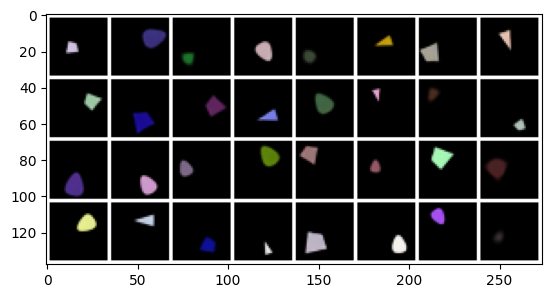

In [17]:
# Extract the `v_latents` domain module
visual_module = cast(VisualLatentDomainModule, global_workspace.domain_mods["v_latents"])

# `train_paired_samples` contains the latent representation, we can use `decode_images`
# of the visual module to get back the actual images:
train_images = visual_module.decode_images(train_paired_samples["v_latents"])


def plot_image_grid(samples: torch.Tensor, nrow=8):
    grid = make_grid(samples, nrow=nrow, pad_value=1).permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(grid)
    plt.show()


plot_image_grid(train_images)

### Text

Let's now look at the text domain:

In [18]:
train_paired_samples["t"]

{'bert': tensor([[-0.0309,  0.4805, -0.6248,  ..., -0.6721, -0.0839,  0.2438],
         [-0.3542, -0.1985,  0.5443,  ..., -1.8060,  0.5431, -0.9113],
         [ 0.8752, -0.1091,  1.7864,  ...,  1.1220,  0.4875, -0.1695],
         ...,
         [-1.9241,  2.2724, -2.2204,  ...,  1.3815, -2.1490,  0.0232],
         [-0.3356, -0.1605,  1.2426,  ..., -0.7230,  0.3664,  1.3595],
         [ 1.2000,  0.4436,  0.0663,  ...,  0.9258,  0.4741, -0.1370]],
        device='cuda:0'),
 'tokens': tensor([[314, 346, 436,  ...,   0,   0,   0],
         [428, 265, 261,  ...,   0,   0,   0],
         [314, 346, 265,  ...,   0,   0,   0],
         ...,
         [429, 265, 261,  ...,   0,   0,   0],
         [295, 265, 261,  ...,   0,   0,   0],
         [ 35, 358, 383,  ...,   0,   0,   0]], device='cuda:0')}

It contains the bert latent representations of the text, and the token sequence. Let's decode the tokens and look at the sentences:

In [19]:
def get_text_samples(samples: dict[str, torch.Tensor]) -> list[str]:
    """
    Decode the token sequence into a full sentence.
    """
    return tokenizer.decode_batch(
        samples["tokens"].detach().cpu().tolist(),
        skip_special_tokens=True,
    )


train_text_samples = get_text_samples(train_paired_samples["t"])
for k, text in enumerate(train_text_samples, 1):
    print(k, text.replace("<pad>", ""))

1 The image contains a thistle colored tiny arrow-shaped polygon. It is in the middle, slightly left. It is pointing towards the southwest.
2 This is a big dark slate blue colored egg, it is located at the upper side right side, it is pointing to the right.
3 The image is a tiny forest green colored object located at the bottom left side, and is pointing towards the northeast, and it looks like a trapezoidal shape.
4 The image contains a medium sized object in silver pointing towards the south-southeast, and is located slightly lower side, at the center, it looks like a guitar pick.
5 It is a tiny dark slate grey object at the bottom, on the left side and is pointing northwest. It looks like an oval shaped structure.
6 A small dark goldenrod isosceles triangle, and is at the middle, and is pointing to the west-southwest.
7 The image contains a medium dark grey trapezoidal shape and it is pointing towards the top-right corner and it is at the bottom, at the left.
8 This is an average si

## Text to Image Translations

Now that we are familiar with the data, let's use the global workspace to do some translations.

We will first encode the raw data into the unimodal latent representations with `encode_domain`:

In [20]:
latent_unimodal_text = global_workspace.encode_domain(train_paired_samples["t"], "t")
print(latent_unimodal_text.size())

torch.Size([32, 64])


Then, we will encode the unimodal text representation into the GW reprensentation. First we encode the reprensentations

In [21]:
t_gw_latent = global_workspace.gw_mod.encode({"t": latent_unimodal_text})
print(t_gw_latent["t"].size())

torch.Size([32, 16])


Then we fuse the latents together. This requires the coefficients that we use for each domain. As we only have one domain, we put all weights to the text domain with:

In [22]:
t_gw_latent_fused = global_workspace.gw_mod.fuse(t_gw_latent, {"t": torch.ones(32).to(device)})
print(t_gw_latent_fused.size())

torch.Size([32, 16])


Finally, we will decode the GW representation:

In [23]:
decoded_latents = global_workspace.gw_mod.decode(t_gw_latent_fused)
print(decoded_latents.keys())

dict_keys(['v_latents', 't'])


As you can see, this decodes to both domains. We will look now at the predicted visual latents.

torch.Size([32, 12])


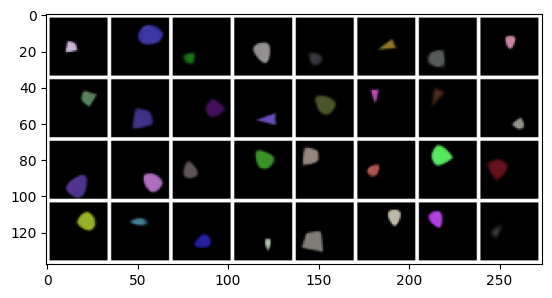

In [24]:
print(decoded_latents["v_latents"].size())
decoded_images = visual_module.decode_images(decoded_latents["v_latents"])
plot_image_grid(decoded_images)

This is the predicted visual translation from text.

## Image to Text translations

You could do the same as in the other side, but we will here look at another method. When the previous method is useful to translate starting from domains. This method can take domain groups and will do the translation for each group.

We here use `encode_domains` instead of `encode_domain` with all groups:

In [25]:
unimodal_latents = global_workspace.encode_domains(train_samples)
print(unimodal_latents.keys())
print(unimodal_latents[frozenset(["t"])])

dict_keys([frozenset({'t'}), frozenset({'v_latents'}), frozenset({'t', 'v_latents'})])
{'t': tensor([[-0.9933, -1.0000, -1.0000,  ...,  1.0000,  1.0000, -0.5814],
        [ 1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000, -0.9995],
        [ 0.8803, -1.0000, -1.0000,  ...,  1.0000,  1.0000, -0.5440],
        ...,
        [-1.0000, -1.0000, -1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [-0.2907, -1.0000, -1.0000,  ...,  1.0000, -1.0000,  1.0000],
        [-0.1505, -1.0000, -1.0000,  ...,  1.0000, -1.0000, -0.4493]],
       device='cuda:0', grad_fn=<TanhBackward0>)}


We see that all domain groups were encoded into latent reprensentations.

We now need a selection module (see [https://ruflab.github.io/shimmer/latest/shimmer/modules/selection.html](https://ruflab.github.io/shimmer/latest/shimmer/modules/selection.html)) that defines the policy on how to fuse the different domains in a group.

We want to use a selection mechanism that only select the image domain and removes the text domain.

All selection mechanism inherit from `SelectionBase` and define the forward which text the unimodal latent representations of the domains, and the pre-fusion encoded representation as parameters:

In [26]:
class OnlyVisionSelection(SelectionBase):
    def forward(
        self, domains: Mapping[str, torch.Tensor], encodings_pre_fusion: Mapping[str, torch.Tensor]
    ) -> dict[str, torch.Tensor]:
        # If only one domain, we keep it
        if len(domains) == 1:
            return {domain: torch.ones(32).to(device) for domain in domains}
        else:
            selection: dict[str, torch.Tensor] = {}
            for domain in domains:
                # We only keep the visual latents
                if domain == "v_latents":
                    selection["v_latents"] = torch.ones(32).to(device)
                else:
                    # and set 0 to all other domain
                    selection[domain] = torch.zeros(32).to(device)
            return selection

In [27]:
selection_mod = OnlyVisionSelection()

In [28]:
gw_latents = global_workspace.encode_and_fuse(unimodal_latents, selection_mod)
print(gw_latents.keys())

dict_keys([frozenset({'t'}), frozenset({'v_latents'}), frozenset({'t', 'v_latents'})])


Finally we can decode all latents and look at reconstructed domains.

In [29]:
decoded_latents = global_workspace.decode(gw_latents)
print(decoded_latents.keys())
reconstructed_domains = global_workspace.decode_domains(decoded_latents)
print(reconstructed_domains.keys())
# We keep the one that are paired. As the selection mechanism only keep the visual domains,
# the text reconstructions are translations, and the images are demi-cycles.
reconstructed_texts = reconstructed_domains[frozenset(["t", "v_latents"])]["t"]
reconstructed_images = reconstructed_domains[frozenset(["t", "v_latents"])]["v_latents"]

dict_keys([frozenset({'t'}), frozenset({'v_latents'}), frozenset({'t', 'v_latents'})])
dict_keys([frozenset({'t'}), frozenset({'v_latents'}), frozenset({'t', 'v_latents'})])


In [30]:
reconstructed_texts.keys()

dict_keys(['token_dist', 'tokens'])

In [31]:
reconstructed_images.size()

torch.Size([32, 12])

First let's look at the original images, and their reconstructions (demi-cycle):

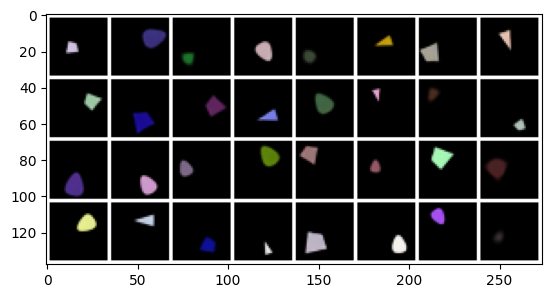

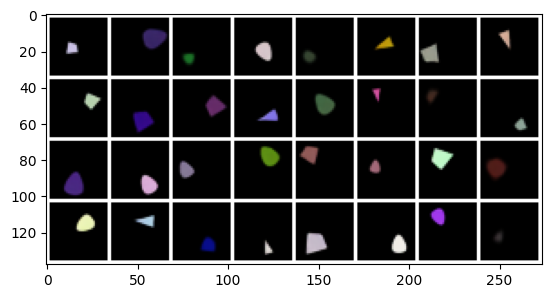

In [32]:
original_images = visual_module.decode_images(train_samples[frozenset(["v_latents", "t"])]["v_latents"])
plot_image_grid(original_images)
decoded_images = visual_module.decode_images(reconstructed_images)
plot_image_grid(decoded_images)

And now let's look at the predicted texts (translations):

In [33]:
reconstructed_text_strings = get_text_samples(reconstructed_texts)
for k, text in enumerate(reconstructed_text_strings, 1):
    print(k, text.replace("<pad>", ""))

1 The image is a thistle colored tiny kite, and is pointing towards the bottom-left corner, and is located at the center left side.
2 The image represents a large shape in dark slate blue color pointing towards the right top-right corner, and is at the upper side right, on the very right side, and looks like a bullet.
3 The image contains a tiny forest green colored shape pointing towards the top-right corner, it is located at the lower side left side, it looks like a kite.
4 The image contains a medium sized silver colored object pointing towards the bottom-right corner, and it is located slightly bottom, at the center, and looks like a bullet.
5 The image represents a tiny dark slate grey colored object pointing towards the top-left corner, and it is located at the bottom, on the left side, and looks like a bullet.
6 The image contains a medium sized dark goldenrod colored triangle, and is pointing towards the left bottom-left corner, and is located slightly top, in the center.
7 The